# Bayesian Temporal Matrix Factorization

**Published**: October 8, 2019

**Revised**: October 8, 2020

**Author**: Xinyu Chen [[**GitHub homepage**](https://github.com/xinychen)]

**Download**: This Jupyter notebook is at our GitHub repository. If you want to evaluate the code, please download the notebook from the [**transdim**](https://github.com/xinychen/transdim/blob/master/predictor/BTMF.ipynb) repository.

This notebook shows how to implement the Bayesian Temporal Matrix Factorization (BTMF), a fully Bayesian matrix factorization model, on some real-world data sets. To overcome the missing data problem in multivariate time series, BTMF takes into account both low-rank matrix structure and time series autoregression. For an in-depth discussion of BTMF, please see [1].

<div class="alert alert-block alert-info">
<font color="black">
<b>[1]</b> Xinyu Chen, Lijun Sun (2019). <b>Bayesian temporal factorization for multidimensional time series prediction</b>. arXiv:1910.06366. <a href="https://arxiv.org/pdf/1910.06366.pdf" title="PDF"><b>[PDF]</b></a> 
</font>
</div>

## Problem Description

We assume a spatiotemporal setting for multidimensional time series data throughout this work. In general, modern spatiotemporal data sets collected from sensor networks can be organized as matrix time series. For example, we can denote by matrix $Y\in\mathbb{R}^{N\times T}$ a multivariate time series collected from $N$ locations/sensors on $T$ time points, with each row $$\boldsymbol{y}_{i}=\left(y_{i,1},y_{i,2},...,y_{i,t-1},y_{i,t},y_{i,t+1},...,y_{i,T}\right)$$
corresponding to the time series collected at location $i$.

As mentioned, making accurate predictions on incomplete time series is very challenging, while missing data problem is almost inevitable in real-world applications. Figure 1 illustrates the prediction problem for incomplete time series data. Here we use $(i,t)\in\Omega$ to index the observed entries in matrix $Y$.

<img src="../images/graphical_matrix_time_series.png" alt="drawing" width="500"/>

> **Figure 1**: Illustration of multivariate time series and the prediction problem in the presence of missing values (green: observed data; white: missing data; red: prediction).


In [33]:
import numpy as np
from numpy.linalg import inv as inv
from numpy.random import normal as normrnd
from numpy.random import multivariate_normal as mvnrnd
from scipy.linalg import khatri_rao as kr_prod
from scipy.stats import wishart
from scipy.stats import invwishart
from numpy.linalg import solve as solve
from numpy.linalg import cholesky as cholesky_lower
from scipy.linalg import cholesky as cholesky_upper
from scipy.linalg import solve_triangular as solve_ut
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
def mvnrnd_pre(mu, Lambda):
    src = normrnd(size = (mu.shape[0],))
    return solve_ut(cholesky_upper(Lambda, overwrite_a = True, check_finite = False), 
                    src, lower = False, check_finite = False, overwrite_b = True) + mu

def cov_mat(mat, mat_bar):
    mat = mat - mat_bar
    return mat.T @ mat

In [35]:
def sample_factor_w(tau_sparse_mat, tau_ind, W, X, tau, beta0 = 1, vargin = 0):
    """Sampling N-by-R factor matrix W and its hyperparameters (mu_w, Lambda_w)."""
    
    dim1, rank = W.shape
    W_bar = np.mean(W, axis = 0)
    temp = dim1 / (dim1 + beta0)
    var_W_hyper = inv(np.eye(rank) + cov_mat(W, W_bar) + temp * beta0 * np.outer(W_bar, W_bar))
    var_Lambda_hyper = wishart.rvs(df = dim1 + rank, scale = var_W_hyper)
    var_mu_hyper = mvnrnd_pre(temp * W_bar, (dim1 + beta0) * var_Lambda_hyper)
    
    if dim1 * rank ** 2 > 1e+8:
        vargin = 1
    
    if vargin == 0:
        var1 = X.T
        var2 = kr_prod(var1, var1)
        var3 = (var2 @ tau_ind.T).reshape([rank, rank, dim1]) + var_Lambda_hyper[:, :, None]
        var4 = var1 @ tau_sparse_mat.T + (var_Lambda_hyper @ var_mu_hyper)[:, None]
        for i in range(dim1):
            W[i, :] = mvnrnd_pre(solve(var3[:, :, i], var4[:, i]), var3[:, :, i])
    elif vargin == 1:
        for i in range(dim1):
            pos0 = np.where(sparse_mat[i, :] != 0)
            Xt = X[pos0[0], :]
            var_mu = tau[i] * Xt.T @ sparse_mat[i, pos0[0]] + var_Lambda_hyper @ var_mu_hyper
            var_Lambda = tau[i] * Xt.T @ Xt + var_Lambda_hyper
            W[i, :] = mvnrnd_pre(solve(var_Lambda, var_mu), var_Lambda)
    
    return W

In [36]:
def mnrnd(M, U, V):
    """
    Generate matrix normal distributed random matrix.
    M is a m-by-n matrix, U is a m-by-m matrix, and V is a n-by-n matrix.
    """
    dim1, dim2 = M.shape
    X0 = np.random.randn(dim1, dim2)
    P = cholesky_lower(U)
    Q = cholesky_lower(V)
    
    return M + P @ X0 @ Q.T

def sample_var_coefficient(X, time_lags):
    dim, rank = X.shape
    d = time_lags.shape[0]
    tmax = np.max(time_lags)
    
    Z_mat = X[tmax : dim, :]
    Q_mat = np.zeros((dim - tmax, rank * d))
    for k in range(d):
        Q_mat[:, k * rank : (k + 1) * rank] = X[tmax - time_lags[k] : dim - time_lags[k], :]
    var_Psi0 = np.eye(rank * d) + Q_mat.T @ Q_mat
    var_Psi = inv(var_Psi0)
    var_M = var_Psi @ Q_mat.T @ Z_mat
    var_S = np.eye(rank) + Z_mat.T @ Z_mat - var_M.T @ var_Psi0 @ var_M
    Sigma = invwishart.rvs(df = rank + dim - tmax, scale = var_S)
    
    return mnrnd(var_M, var_Psi, Sigma), Sigma

In [37]:
def sample_factor_x(tau_sparse_mat, tau_ind, time_lags, W, X, A, Lambda_x):
    """Sampling T-by-R factor matrix X."""
    
    dim2, rank = X.shape
    tmax = np.max(time_lags)
    tmin = np.min(time_lags)
    d = time_lags.shape[0]
    A0 = np.dstack([A] * d)
    for k in range(d):
        A0[k * rank : (k + 1) * rank, :, k] = 0
    mat0 = Lambda_x @ A.T
    mat1 = np.einsum('kij, jt -> kit', A.reshape([d, rank, rank]), Lambda_x)
    mat2 = np.einsum('kit, kjt -> ij', mat1, A.reshape([d, rank, rank]))
    
    var1 = W.T
    var2 = kr_prod(var1, var1)
    var3 = (var2 @ tau_ind).reshape([rank, rank, dim2]) + Lambda_x[:, :, None]
    var4 = var1 @ tau_sparse_mat
    for t in range(dim2):
        Mt = np.zeros((rank, rank))
        Nt = np.zeros(rank)
        Qt = mat0 @ X[t - time_lags, :].reshape(rank * d)
        index = list(range(0, d))
        if t >= dim2 - tmax and t < dim2 - tmin:
            index = list(np.where(t + time_lags < dim2))[0]
        elif t < tmax:
            Qt = np.zeros(rank)
            index = list(np.where(t + time_lags >= tmax))[0]
        if t < dim2 - tmin:
            Mt = mat2.copy()
            temp = np.zeros((rank * d, len(index)))
            n = 0
            for k in index:
                temp[:, n] = X[t + time_lags[k] - time_lags, :].reshape(rank * d)
                n += 1
            temp0 = X[t + time_lags[index], :].T - np.einsum('ijk, ik -> jk', A0[:, :, index], temp)
            Nt = np.einsum('kij, jk -> i', mat1[index, :, :], temp0)
        
        var3[:, :, t] = var3[:, :, t] + Mt
        if t < tmax:
            var3[:, :, t] = var3[:, :, t] - Lambda_x + np.eye(rank)
        X[t, :] = mvnrnd_pre(solve(var3[:, :, t], var4[:, t] + Nt + Qt), var3[:, :, t])

    return X

In [38]:
def sample_precision_tau(sparse_mat, mat_hat, ind):
    var_alpha = 1e-6 + 0.5 * np.sum(ind, axis = 1)
    var_beta = 1e-6 + 0.5 * np.sum(((sparse_mat - mat_hat) ** 2) * ind, axis = 1)
    return np.random.gamma(var_alpha, 1 / var_beta)

def sample_precision_scalar_tau(sparse_mat, mat_hat, ind):
    var_alpha = 1e-6 + 0.5 * np.sum(ind)
    var_beta = 1e-6 + 0.5 * np.sum(((sparse_mat - mat_hat) ** 2) * ind)
    return np.random.gamma(var_alpha, 1 / var_beta)

In [39]:
"""
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_rmse(var, var_hat):
    return  np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

import numpy as np

def compute_mape(var, var_hat):
    valid_indices = ~np.isnan(var) & ~np.isnan(var_hat)
    return np.sum(np.abs(var[valid_indices] - var_hat[valid_indices]) / var[valid_indices]) / valid_indices.sum()

def compute_rmse(var, var_hat):
    valid_indices = ~np.isnan(var) & ~np.isnan(var_hat)
    return np.sqrt(np.sum((var[valid_indices] - var_hat[valid_indices]) ** 2) / valid_indices.sum())
"""
import numpy as np
def compute_mape(var, var_hat):
    valid_indices = ~np.isnan(var) & ~np.isnan(var_hat) & (var != 0)
    if valid_indices.sum() == 0:  # Check if there are valid indices
        return np.nan
    return np.sum(np.abs(var[valid_indices] - var_hat[valid_indices]) / var[valid_indices]) / valid_indices.sum()

def compute_rmse(var, var_hat):
    valid_indices = ~np.isnan(var) & ~np.isnan(var_hat)
    if valid_indices.sum() == 0:  # Check if there are valid indices
        return np.nan
    return np.sqrt(np.sum((var[valid_indices] - var_hat[valid_indices]) ** 2) / valid_indices.sum())


In [40]:
def ar4cast(A, X, Sigma, time_lags, multi_step):
    dim, rank = X.shape
    d = time_lags.shape[0]
    X_new = np.append(X, np.zeros((multi_step, rank)), axis = 0)
    for t in range(multi_step):
        var = A.T @ X_new[dim + t - time_lags, :].reshape(rank * d)
        X_new[dim + t, :] = mvnrnd(var, Sigma)
    return X_new

#### BTMF Implementation



In [41]:
def BTMF(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter, multi_step = 1, option = "factor"):
    """Bayesian Temporal Matrix Factorization, BTMF."""
    
    dim1, dim2 = sparse_mat.shape
    d = time_lags.shape[0]
    W = init["W"]
    X = init["X"]
    if np.isnan(sparse_mat).any() == False:
        ind = sparse_mat != 0
        pos_obs = np.where(ind)
        pos_test = np.where((dense_mat != 0) & (sparse_mat == 0))
    elif np.isnan(sparse_mat).any() == True:
        pos_test = np.where((dense_mat != 0) & (np.isnan(sparse_mat)))
        ind = ~np.isnan(sparse_mat)
        pos_obs = np.where(ind)
        sparse_mat[np.isnan(sparse_mat)] = 0
    dense_test = dense_mat[pos_test]
    del dense_mat
    tau = np.ones(dim1)
    W_plus = np.zeros((dim1, rank, gibbs_iter))
    A_plus = np.zeros((rank * d, rank, gibbs_iter))
    tau_plus = np.zeros((dim1, gibbs_iter))
    Sigma_plus = np.zeros((rank, rank, gibbs_iter))
    temp_hat = np.zeros(len(pos_test[0]))
    show_iter = 500
    mat_hat_plus = np.zeros((dim1, dim2))
    X_plus = np.zeros((dim2 + multi_step, rank, gibbs_iter))
    mat_new_plus = np.zeros((dim1, multi_step))
    for it in range(burn_iter + gibbs_iter):
        tau_ind = tau[:, None] * ind
        tau_sparse_mat = tau[:, None] * sparse_mat
        W = sample_factor_w(tau_sparse_mat, tau_ind, W, X, tau, beta0 = 1, vargin = 0)
        A, Sigma = sample_var_coefficient(X, time_lags)
        X = sample_factor_x(tau_sparse_mat, tau_ind, time_lags, W, X, A, inv(Sigma))
        mat_hat = W @ X.T
        if option == "factor":
            tau = sample_precision_tau(sparse_mat, mat_hat, ind)
        elif option == "pca":
            tau = sample_precision_scalar_tau(sparse_mat, mat_hat, ind)
            tau = tau * np.ones(dim1)
        temp_hat += mat_hat[pos_test]
        if (it + 1) % show_iter == 0 and it < burn_iter:
            temp_hat = temp_hat / show_iter
            print('Iter: {}'.format(it + 1))
            print('MAPE: {:.6}'.format(compute_mape(dense_test, temp_hat)))
            print('RMSE: {:.6}'.format(compute_rmse(dense_test, temp_hat)))
            temp_hat = np.zeros(len(pos_test[0]))
            print()
        if it + 1 > burn_iter:
            W_plus[:, :, it - burn_iter] = W
            A_plus[:, :, it - burn_iter] = A
            Sigma_plus[:, :, it - burn_iter] = Sigma
            tau_plus[:, it - burn_iter] = tau
            mat_hat_plus += mat_hat
            X0 = ar4cast(A, X, Sigma, time_lags, multi_step)
            X_plus[:, :, it - burn_iter] = X0
            mat_new_plus += W @ X0[dim2 : dim2 + multi_step, :].T
    mat_hat = mat_hat_plus / gibbs_iter
    #print('Imputation MAPE: {:.6}'.format(compute_mape(dense_test, mat_hat[:, : dim2][pos_test])))
    #print('Imputation RMSE: {:.6}'.format(compute_rmse(dense_test, mat_hat[:, : dim2][pos_test])))
    print()
    mat_hat = np.append(mat_hat, mat_new_plus / gibbs_iter, axis = 1)
    mat_hat[mat_hat < 0] = 0
    
    return mat_hat, W_plus, X_plus, A_plus, Sigma_plus, tau_plus

In [42]:
def sample_factor_x_partial(tau_sparse_mat, tau_ind, time_lags, W, X, A, Lambda_x, back_step):
    """Sampling T-by-R factor matrix X."""
    
    dim2, rank = X.shape
    tmax = np.max(time_lags)
    tmin = np.min(time_lags)
    d = time_lags.shape[0]
    A0 = np.dstack([A] * d)

    for k in range(d):
        A0[k * rank : (k + 1) * rank, :, k] = 0
    mat0 = Lambda_x @ A.T
    mat1 = np.einsum('kij, jt -> kit', A.reshape([d, rank, rank]), Lambda_x)
    mat2 = np.einsum('kit, kjt -> ij', mat1, A.reshape([d, rank, rank]))
    
    var1 = W.T
    var2 = kr_prod(var1, var1)
    var3 = (var2 @ tau_ind[:, - back_step :]).reshape([rank, rank, back_step]) + Lambda_x[:, :, None]
    var4 = var1 @ tau_sparse_mat[:, - back_step :]
    for t in range(dim2 - back_step, dim2):
        Mt = np.zeros((rank, rank))
        Nt = np.zeros(rank)
        Qt = mat0 @ X[t - time_lags, :].reshape(rank * d)
        index = list(range(0, d))
        if t >= dim2 - tmax and t < dim2 - tmin:
            index = list(np.where(t + time_lags < dim2))[0]
        if t < dim2 - tmin:
            Mt = mat2.copy()
            temp = np.zeros((rank * d, len(index)))
            n = 0
            for k in index:
                temp[:, n] = X[t + time_lags[k] - time_lags, :].reshape(rank * d)
                n += 1
            temp0 = X[t + time_lags[index], :].T - np.einsum('ijk, ik -> jk', A0[:, :, index], temp)
            Nt = np.einsum('kij, jk -> i', mat1[index, :, :], temp0)
        var3[:, :, t + back_step - dim2] = var3[:, :, t + back_step - dim2] + Mt
        X[t, :] = mvnrnd_pre(solve(var3[:, :, t + back_step - dim2], 
                                   var4[:, t + back_step - dim2] + Nt + Qt), var3[:, :, t + back_step - dim2])
    return X
    """
    for t in range(tmax + back_step, dim2):
        Qt = np.eye(rank)
        Mt = np.einsum('ijk, ik -> jk', A0, X[t - time_lags, :])
        Mt = np.matmul(Lambda_x, Mt)
        var1 = np.matmul(W.T, np.matmul(np.diag(tau_sparse_mat[:, t]), W))
        var2 = np.matmul(W.T, tau_sparse_mat[:, t] * tau_ind[:, t])
        var3 = var1 + Qt
        var4 = var2 + Mt
        X[t, :] = np.random.multivariate_normal(np.matmul(np.linalg.inv(var3), var4), np.linalg.inv(var3))

    return X
    """

In [43]:
def BTMF_partial(dense_mat, sparse_mat, init, rank, time_lags, burn_iter, gibbs_iter, multi_step = 1, gamma = 10):
    """Bayesian Temporal Matrix Factorization, BTMF."""
    
    dim1, dim2 = sparse_mat.shape
    W_plus = init["W_plus"]
    X_plus = init["X_plus"]
    A_plus = init["A_plus"]
    Sigma_plus = init["Sigma_plus"]
    tau_plus = init["tau_plus"]
    if np.isnan(sparse_mat).any() == False:
        ind = sparse_mat != 0
        pos_obs = np.where(ind)
    elif np.isnan(sparse_mat).any() == True:
        ind = ~np.isnan(sparse_mat)
        pos_obs = np.where(ind)
        sparse_mat[np.isnan(sparse_mat)] = 0
    X_new_plus = np.zeros((dim2 + multi_step, rank, gibbs_iter))
    mat_new_plus = np.zeros((dim1, multi_step))
    back_step = gamma * multi_step
    for it in range(gibbs_iter):
        print("Iteration ", it)
        tau_ind = tau_plus[:, it][:, None] * ind
        tau_sparse_mat = tau_plus[:, it][:, None] * sparse_mat
        X = sample_factor_x_partial(tau_sparse_mat, tau_ind, time_lags, W_plus[:, :, it], 
                                    X_plus[:, :, it], A_plus[:, :, it], inv(Sigma_plus[:, :, it]), back_step)
        X0 = ar4cast(A_plus[:, :, it], X, Sigma_plus[:, :, it], time_lags, multi_step)
        X_new_plus[:, :, it] = X0
        mat_new_plus += W_plus[:, :, it] @ X0[- multi_step :, :].T
    mat_hat = mat_new_plus / gibbs_iter
    mat_hat[mat_hat < 0] = 0
    
    return mat_hat, W_plus, X_new_plus, A_plus, Sigma_plus, tau_plus

In [44]:
from IPython.display import display

def BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, 
                  rank, time_lags, burn_iter, gibbs_iter, option = "factor", gamma = 10):
    dim1, T = dense_mat.shape
    start_time = T - pred_step
    max_count = int(np.ceil(pred_step / multi_step))
    mat_hat = np.zeros((dim1, max_count * multi_step))
    mape_values=[]
    rmse_values=[]
    #f = IntProgress(min = 0, max = max_count) # instantiate the bar
    #display(f) # display the bar
    for t in range(max_count):
        if t == 0:
            init = {"W": 0.1 * np.random.randn(dim1, rank), "X": 0.1 * np.random.randn(start_time, rank)}
            mat, W, X_new, A, Sigma, tau = BTMF(dense_mat[:, 0 : start_time], 
                sparse_mat[:, 0 : start_time], init, rank, time_lags, burn_iter, gibbs_iter, multi_step, option)
        else:
            init = {"W_plus": W, "X_plus": X_new, "A_plus": A, "Sigma_plus": Sigma, "tau_plus": tau}
            mat, W, X_new, A, Sigma, tau = BTMF_partial(dense_mat[:, 0 : start_time + t * multi_step], 
                sparse_mat[:, 0 : start_time + t * multi_step], init, rank, time_lags, 
                burn_iter, gibbs_iter, multi_step, gamma)
            small_dense_mat = dense_mat[:, start_time : T]
            pos = np.where(small_dense_mat != 0)
            mape_loss = compute_mape(small_dense_mat[pos], mat_hat[pos])  # or compute_mape, based on your preference
            mape_values.append(mape_loss)
            rmse_loss = compute_rmse(small_dense_mat[pos], mat_hat[pos])  # or compute_mape, based on your preference
            rmse_values.append(rmse_loss)
            if t%50 == 0:
                print('Prediction MAPE: {:.6}'.format(mape_loss))
                print('Prediction RMSE: {:.6}'.format(rmse_loss))
        mat_hat[:, t * multi_step : (t + 1) * multi_step] = mat[:, - multi_step :]
        #f.value = t
    small_dense_mat = dense_mat[:, start_time : T]
    pos = np.where(small_dense_mat != 0)
    mape_value = compute_mape(small_dense_mat[pos], mat_hat[pos])
    rmse_value = compute_rmse(small_dense_mat[pos], mat_hat[pos])
    print('Prediction MAPE: {:.6}'.format(mape_value))
    print('Prediction RMSE: {:.6}'.format(rmse_value))
    print()
    return mat_hat, mape_values, rmse_values

In [45]:
from datetime import datetime
from distutils.util import strtobool

import pandas as pd

def convert_tsf_to_dataframe(full_file_path_and_name, replace_missing_vals_with="NaN", value_column_name="series_value",):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )



In [46]:
import pandas as pd

# Read the .tsf file

# Convert to DataFrame

loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("C:/Users/Rohit/Documents/Exeter-Placement/Challenge/phase_1 data/phase_1_data/phase_1_data.tsf")

#print(loaded_data)
#print(loaded_data.shape,frequency, forecast_horizon, contain_missing_values, contain_equal_length)
building_data = loaded_data[loaded_data['series_name'].str.contains('Building')]

max_start_timestamp = building_data['start_timestamp'].max()

building_data['num_timestamps'] = building_data['series_value'].apply(len)

min_timestamps = building_data['num_timestamps'].min()

# Trim each time series to have the same length as the shortest one
building_data['uniform_series'] = building_data['series_value'].apply(lambda x: x[-min_timestamps:])

# Update the 'num_timestamps' column to reflect the new uniform length
building_data['num_timestamps'] = building_data['uniform_series'].apply(len)




"""
# 3. Calculate the number of 15-minute intervals to trim for each series
building_data['intervals_to_trim'] = building_data['start_timestamp'].apply(lambda x: int((x - max_start_timestamp).total_seconds() // (15*60)))

# 4. Trim the time series of each building from the beginning up to this timestamp
building_data['trimmed_series'] = building_data.apply(lambda row: row['series_value'][row['intervals_to_trim']:], axis=1)

# 5. Determine the minimum length of the trimmed series
min_length = building_data['trimmed_series'].apply(len).min()

# 6. Trim (or pad) all series to this minimum length
building_data['uniform_series'] = building_data['trimmed_series'].apply(lambda x: x[:min_length])

#print(building_data)
#print(building_data['uniform_series'].shape)

# 7. Convert the uniform series to a matrix format
matrix = np.array(building_data['uniform_series'].tolist())
"""

C:\Users\Rohit\AppData\Local\Temp\ipykernel_19124\700676220.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  building_data['num_timestamps'] = building_data['series_value'].apply(len)
C:\Users\Rohit\AppData\Local\Temp\ipykernel_19124\700676220.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  building_data['uniform_series'] = building_data['series_value'].apply(lambda x: x[-min_timestamps:])
C:\Users\Rohit\AppData\Local\Temp\ipykernel_19124\700676220.py:23: SettingWithCopyWarning: 
A value is trying 

"\n# 3. Calculate the number of 15-minute intervals to trim for each series\nbuilding_data['intervals_to_trim'] = building_data['start_timestamp'].apply(lambda x: int((x - max_start_timestamp).total_seconds() // (15*60)))\n\n# 4. Trim the time series of each building from the beginning up to this timestamp\nbuilding_data['trimmed_series'] = building_data.apply(lambda row: row['series_value'][row['intervals_to_trim']:], axis=1)\n\n# 5. Determine the minimum length of the trimmed series\nmin_length = building_data['trimmed_series'].apply(len).min()\n\n# 6. Trim (or pad) all series to this minimum length\nbuilding_data['uniform_series'] = building_data['trimmed_series'].apply(lambda x: x[:min_length])\n\n#print(building_data)\n#print(building_data['uniform_series'].shape)\n\n# 7. Convert the uniform series to a matrix format\nmatrix = np.array(building_data['uniform_series'].tolist())\n"

dense mat shape (6, 41572)
[['NaN' 'NaN' 'NaN' ... 37.4 37.4 37.4]
 [26.6 6.2 12.7 ... 4.5 9.6 14.0]
 [690.0 795.0 795.0 ... 415.0 415.0 415.0]
 [1.0 1.0 1.0 ... 'NaN' 'NaN' 'NaN']
 [30.0 31.0 24.0 ... 'NaN' 'NaN' 'NaN']
 [40.0 40.0 35.6 ... 38.6 38.6 38.6]]
starting prediction
Prediction time horizon (delta) = 1.

Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iteration  0
Iteration  1
Iterati

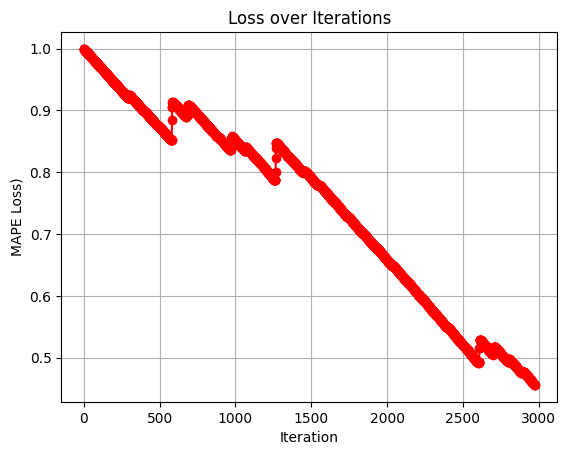

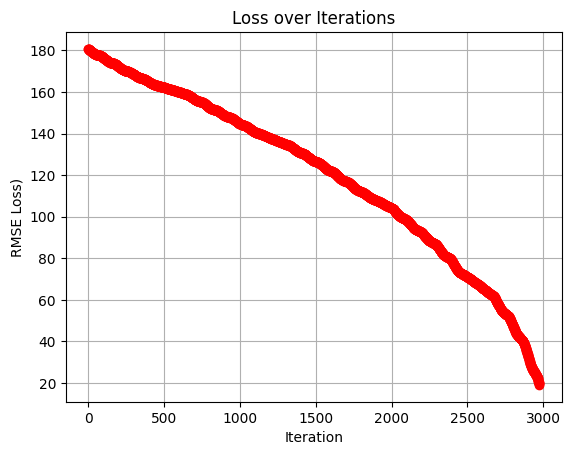

[[164.06897157 175.40548122 170.37433989 ...  75.50392048  55.00188655
    0.        ]
 [ 18.16148991   9.45669799  10.2312105  ...   7.031771     8.51284036
   14.78420112]
 [495.2694534  517.63783381 509.87025956 ... 399.51566995 426.47520578
  403.06368865]
 [  1.53373417   1.33932806   1.3249076  ...   1.31815253   1.35084289
    1.50143686]
 [ 23.05830408  22.6053366   21.35551549 ...  18.33385716  18.49562781
   17.76308774]
 [ 37.56524618  34.40568993  33.50122986 ...  35.86928614  35.11321174
   37.28735645]]
Running time: 78 seconds

(6, 2976)


<Figure size 1000x500 with 0 Axes>

In [47]:
import scipy.io
import numpy as np
import time
import datetime

# Assuming loaded_data is already prepared and is in the format of a dense matrix
dense_mat = building_data['uniform_series']  # Adjust this based on how you've prepared loaded_data

  # Assuming you want to work on a copy of the original data

list_of_arrays = [np.array(series) for series in dense_mat]
mape_values = []
rmse_values = []
# Stack these arrays vertically to form a 2D matrix
dense_mat_2d = np.vstack(list_of_arrays)
sparse_mat = dense_mat_2d.copy()
print("dense mat shape",dense_mat_2d.shape)
print(dense_mat_2d)
dense_mat_2d = np.where(dense_mat_2d == 'NaN', np.nan, dense_mat_2d).astype(float)
sparse_mat = np.where(sparse_mat == 'NaN', np.nan, sparse_mat).astype(float)

# Model Setting
rank = 10
pred_step = 2976 
time_lags = np.array([1, 4, 96])  
#time_lags = np.array([1, 96, 384])  # Adjust this based on the seasonality or patterns in your data#
burn_iter = 10
gibbs_iter = 2
multi_step = 1
dim1, dim2 = sparse_mat.shape
init = {"W": 0.1 * np.random.randn(dim1, rank), "X": 0.1 * np.random.randn(dim2, rank)}
print("starting prediction")
# Apply BTMF forecasting for different prediction time horizons (if needed)

start = time.time()
print('Prediction time horizon (delta) = {}.'.format(multi_step))
building_mat_hat, mape_values, rmse_values = BTMF_forecast(dense_mat_2d, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
plt.plot(mape_values, marker='o', color='red')
plt.title('Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('MAPE Loss)')
plt.grid(True)
filename = "C:/Users/Rohit/Documents/Exeter-Placement/Results/mape_plot_" + datetime.datetime.now().strftime('%Y%m%d_%H%M%S') + ".png"
plt.savefig(filename)
plt.show()

plt.plot(rmse_values, marker='o', color='red')
plt.title('Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('RMSE Loss)')
plt.grid(True)
filename = "C:/Users/Rohit/Documents/Exeter-Placement/Results/rmse_plot_" + datetime.datetime.now().strftime('%Y%m%d_%H%M%S') + ".png"
plt.savefig(filename)
plt.show()

print(building_mat_hat)
end = time.time()
print('Running time: %d seconds'%(end - start))
print()
print(building_mat_hat.shape)
plt.figure(figsize=(10, 5))


plt.tight_layout()
plt.show()

In [48]:
# Read the .tsf file

"""
import pandas as pd

# Read the .tsf file

# Convert to DataFrame
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("C:/Users/Rohit/Documents/Exeter-Placement/Challenge/phase_1 data/phase_1_data/phase_1_data.tsf")
#print(loaded_data.shape,frequency, forecast_horizon, contain_missing_values, contain_equal_length)
solar_data = loaded_data[loaded_data['series_name'].str.contains('Solar')]
#print(building_data)
# 2. Determine the maximum starting timestamp among the buildings

max_start_timestamp = solar_data['start_timestamp'].max()
#print("max timestamp",max_start_timestamp)
solar_data['num_timestamps'] = solar_data['series_value'].apply(len)
#print(solar_data['num_timestamps'])
min_timestamps = solar_data['num_timestamps'].min()

# Trim each time series to have the same length as the shortest one
solar_data['uniform_series'] = solar_data['series_value'].apply(lambda x: x[-min_timestamps:])

# Update the 'num_timestamps' column to reflect the new uniform length
solar_data['num_timestamps'] = solar_data['uniform_series'].apply(len)
#print(solar_data['uniform_series'])
"""

'\nimport pandas as pd\n\n# Read the .tsf file\n\n# Convert to DataFrame\nloaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("C:/Users/Rohit/Documents/Exeter-Placement/Challenge/phase_1 data/phase_1_data/phase_1_data.tsf")\n#print(loaded_data.shape,frequency, forecast_horizon, contain_missing_values, contain_equal_length)\nsolar_data = loaded_data[loaded_data[\'series_name\'].str.contains(\'Solar\')]\n#print(building_data)\n# 2. Determine the maximum starting timestamp among the buildings\n\nmax_start_timestamp = solar_data[\'start_timestamp\'].max()\n#print("max timestamp",max_start_timestamp)\nsolar_data[\'num_timestamps\'] = solar_data[\'series_value\'].apply(len)\n#print(solar_data[\'num_timestamps\'])\nmin_timestamps = solar_data[\'num_timestamps\'].min()\n\n# Trim each time series to have the same length as the shortest one\nsolar_data[\'uniform_series\'] = solar_data[\'series_value\'].apply(lambda x: x[-min_timestamp

test starting
   series_name     start_timestamp  \
0    Building0 2016-07-03 21:30:00   
1    Building1 2019-01-09 23:15:00   
2    Building3 2016-03-01 04:15:00   
3    Building4 2019-07-03 04:45:00   
4    Building5 2019-07-25 23:00:00   
5    Building6 2019-07-25 01:45:00   
6       Solar0 2020-04-25 14:00:00   
7       Solar1 2018-12-31 13:00:00   
8       Solar2 2019-06-05 14:00:00   
9       Solar3 2019-06-05 14:00:00   
10      Solar4 2019-06-05 14:00:00   
11      Solar5 2019-01-15 13:00:00   

                                         series_value  
0   [283.8, 283.8, 283.8, 606.0, 606.0, 606.0, 606...  
1   [8.1, 15.7, 22.8, 32.7, 8.1, 16.5, 24.7, 34.5,...  
2   [1321.0, 1321.0, 1321.0, 1321.0, 1293.0, 1293....  
3   [2.0, NaN, 1.0, 2.0, NaN, 2.0, NaN, NaN, 2.0, ...  
4   [30.0, 31.0, 24.0, 34.0, 30.0, 31.0, 26.0, 33....  
5   [36.8, 34.6, 34.6, 36.2, 36.2, 35.2, 35.2, 35....  
6   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
7   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

C:\Users\Rohit\AppData\Local\Temp\ipykernel_19124\2660718443.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  building_data['num_timestamps'] = building_data['series_value'].apply(len)
C:\Users\Rohit\AppData\Local\Temp\ipykernel_19124\2660718443.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  building_data['uniform_series'] = building_data['series_value'].apply(lambda x: x[-min_timestamps:])
C:\Users\Rohit\AppData\Local\Temp\ipykernel_19124\2660718443.py:231: SettingWithCopyWarning: 
A value is t


Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  0
Iteration  1
Iteration  2
Iteration  3

AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

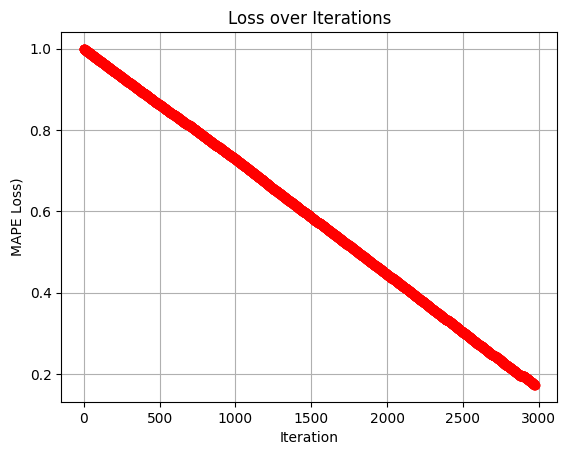

In [49]:
import scipy.io
import numpy as np
import time
import datetime
print("test starting")
# Convert to DataFrame
from datetime import datetime
from distutils.util import strtobool
import matplotlib.pyplot as plt
import pandas as pd

def convert_tsf_to_dataframe(full_file_path_and_name, replace_missing_vals_with="NaN", value_column_name="series_value",):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )

from IPython.display import display

def BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, 
                  rank, time_lags, burn_iter, gibbs_iter, option = "factor", gamma = 10):
    dim1, T = dense_mat.shape
    start_time = T - pred_step
    max_count = int(np.ceil(pred_step / multi_step))
    mat_hat = np.zeros((dim1, max_count * multi_step))
    mape_values=[]
    rmse_values=[]
    #f = IntProgress(min = 0, max = max_count) # instantiate the bar
    #display(f) # display the bar
    for t in range(max_count):
        if t == 0:
            init = {"W": 0.1 * np.random.randn(dim1, rank), "X": 0.1 * np.random.randn(start_time, rank)}
            mat, W, X_new, A, Sigma, tau = BTMF(dense_mat[:, 0 : start_time], 
                sparse_mat[:, 0 : start_time], init, rank, time_lags, burn_iter, gibbs_iter, multi_step, option)
        else:
            init = {"W_plus": W, "X_plus": X_new, "A_plus": A, "Sigma_plus": Sigma, "tau_plus": tau}
            mat, W, X_new, A, Sigma, tau = BTMF_partial(dense_mat[:, 0 : start_time + t * multi_step], 
                sparse_mat[:, 0 : start_time + t * multi_step], init, rank, time_lags, 
                burn_iter, gibbs_iter, multi_step, gamma)
            small_dense_mat = dense_mat[:, start_time : T]
            pos = np.where(small_dense_mat != 0)
            mape_loss = compute_mape(small_dense_mat[pos], mat_hat[pos])  # or compute_mape, based on your preference
            mape_values.append(mape_loss)
            rmse_loss = compute_rmse(small_dense_mat[pos], mat_hat[pos])  # or compute_mape, based on your preference
            rmse_values.append(rmse_loss)
            if t%50 == 0:
                print('Prediction MAPE: {:.6}'.format(mape_loss))
                print('Prediction RMSE: {:.6}'.format(rmse_loss))
        mat_hat[:, t * multi_step : (t + 1) * multi_step] = mat[:, - multi_step :]
        #f.value = t
    small_dense_mat = dense_mat[:, start_time : T]
    pos = np.where(small_dense_mat != 0)
    mape_value = compute_mape(small_dense_mat[pos], mat_hat[pos])
    rmse_value = compute_rmse(small_dense_mat[pos], mat_hat[pos])
    print('Prediction MAPE: {:.6}'.format(mape_value))
    print('Prediction RMSE: {:.6}'.format(rmse_value))
    print()
    return mat_hat, mape_values, rmse_values
"""
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("C:/Users/Rohit/Documents/Exeter-Placement/Challenge/phase_1 data/phase_1_data/phase_1_data.tsf")

print(loaded_data)
#print(loaded_data.shape,frequency, forecast_horizon, contain_missing_values, contain_equal_length)
solar_data = loaded_data[loaded_data['series_name'].str.contains('solar')]

max_start_timestamp = solar_data['start_timestamp'].max()

solar_data['num_timestamps'] = solar_data['series_value'].apply(len)

min_timestamps = solar_data['num_timestamps'].min()

# Trim each time series to have the same length as the shortest one
solar_data['uniform_series'] = solar_data['series_value'].apply(lambda x: x[-min_timestamps:])

# Update the 'num_timestamps' column to reflect the new uniform length
solar_data['num_timestamps'] = solar_data['uniform_series'].apply(len)

# Assuming loaded_data is already prepared and is in the format of a dense matrix
dense_mat = solar_data['uniform_series']  # Adjust this based on how you've prepared loaded_data
"""
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("C:/Users/Rohit/Documents/Exeter-Placement/Challenge/phase_1 data/phase_1_data/phase_1_data.tsf")

print(loaded_data)
#print(loaded_data.shape,frequency, forecast_horizon, contain_missing_values, contain_equal_length)
building_data = loaded_data[loaded_data['series_name'].str.contains('Solar')]

max_start_timestamp = building_data['start_timestamp'].max()

building_data['num_timestamps'] = building_data['series_value'].apply(len)

min_timestamps = building_data['num_timestamps'].min()

# Trim each time series to have the same length as the shortest one
building_data['uniform_series'] = building_data['series_value'].apply(lambda x: x[-min_timestamps:])

# Update the 'num_timestamps' column to reflect the new uniform length
building_data['num_timestamps'] = building_data['uniform_series'].apply(len)
  # Assuming you want to work on a copy of the original data

list_of_arrays = [np.array(series) for series in dense_mat]
mape_values = []
rmse_values = []
# Stack these arrays vertically to form a 2D matrix
dense_mat_2d = np.vstack(list_of_arrays)
sparse_mat = dense_mat_2d.copy()
print("dense mat shape",dense_mat_2d.shape)
print(dense_mat_2d)
dense_mat_2d = np.where(dense_mat_2d == 'NaN', np.nan, dense_mat_2d).astype(float)
sparse_mat = np.where(sparse_mat == 'NaN', np.nan, sparse_mat).astype(float)

# Model Setting
rank = 10
pred_step = 2976 
time_lags = np.array([1, 4, 96])  
#time_lags = np.array([1, 96, 384])  # Adjust this based on the seasonality or patterns in your data#
burn_iter = 50
gibbs_iter = 12
multi_step = 1
dim1, dim2 = sparse_mat.shape
init = {"W": 0.1 * np.random.randn(dim1, rank), "X": 0.1 * np.random.randn(dim2, rank)}
print("starting prediction")
# Apply BTMF forecasting for different prediction time horizons (if needed)

start = time.time()
print('Prediction time horizon (delta) = {}.'.format(multi_step))
building_mat_hat, mape_values, rmse_values = BTMF_forecast(dense_mat_2d, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
plt.plot(mape_values, marker='o', color='red')
plt.title('Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('MAPE Loss)')
plt.grid(True)
filename = "C:/Users/Rohit/Documents/Exeter-Placement/Results/mape_plot_" + datetime.datetime.now().strftime('%Y%m%d_%H%M%S') + ".png"
plt.savefig(filename)
plt.show()

plt.plot(rmse_values, marker='o', color='red')
plt.title('Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('RMSE Loss)')
plt.grid(True)
filename = "C:/Users/Rohit/Documents/Exeter-Placement/Results/rmse_plot_" + datetime.datetime.now().strftime('%Y%m%d_%H%M%S') + ".png"
plt.savefig(filename)
plt.show()

print(building_mat_hat)
end = time.time()
print('Running time: %d seconds'%(end - start))
print()
print(building_mat_hat.shape)
plt.figure(figsize=(10, 5))


plt.tight_layout()
plt.show()
"""
import scipy.io
import numpy as np

# Assuming loaded_data is already prepared and is in the format of a dense matrix
dense_mat = solar_data['uniform_series']  # Adjust this based on how you've prepared loaded_data

  # Assuming you want to work on a copy of the original data

list_of_arrays = [np.array(series) for series in dense_mat]

# Stack these arrays vertically to form a 2D matrix
dense_mat_2d = np.vstack(list_of_arrays)
sparse_mat = dense_mat_2d.copy()
print("dense mat shape",dense_mat_2d.shape)
print(dense_mat_2d)
dense_mat_2d = np.where(dense_mat_2d == 'NaN', np.nan, dense_mat_2d).astype(float)
sparse_mat = np.where(sparse_mat == 'NaN', np.nan, sparse_mat).astype(float)

# Model Setting
rank = 10
pred_step = 2976  # You mentioned you want to predict the next 248 energy demand values
time_lags = np.array([1, 4, 96])  # Adjust this based on the seasonality or patterns in your data#
burn_iter = 2
gibbs_iter = 1
dim1, dim2 = sparse_mat.shape
init = {"W": 0.1 * np.random.randn(dim1, rank), "X": 0.1 * np.random.randn(dim2, rank)}

BTMFburn=2
BTMFgibbs=1
matrix, W_plus, X_plus, A_plus, Sigma_plus, tau_plus=BTMF(dense_mat_2d, sparse_mat, init, rank, time_lags, BTMFburn, BTMFgibbs, multi_step = 1, option = "factor")
print("matrix shape: ", matrix.shape)
print(matrix)

df = pd.DataFrame(matrix)  # Assuming mat_hat is your data matrix
df.to_csv('C:/Users/Rohit/Documents/Exeter-Placement/Results/solar_predicted_data.csv', index=False)

print("starting prediction")
# Apply BTMF forecasting for different prediction time horizons (if needed)
for multi_step in [4, 24, 48, 96, 672]:  # Adjust this list based on your requirements
    start = time.time()
    print('Prediction time horizon (delta) = {}.'.format(multi_step))
    solar_mat_hat = BTMF_forecast(dense_mat_2d, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
    print(solar_mat_hat)
    end = time.time()
    print('Running time: %d seconds'%(end - start))
    print()
print(solar_mat_hat.shape)
"""

## Evaluation on Guangzhou Speed Data



**Scenario setting**:

- Tensor size: $214\times 61\times 144$ (road segment, day, time of day)
- Test on original data


In [ ]:
import scipy.io
import warnings
warnings.simplefilter('ignore')

tensor = scipy.io.loadmat('C:/Users/Rohit/Documents/Exeter-Placement/transdim-master/datasets/Guangzhou-data-set/tensor.mat')['tensor']
dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
sparse_mat = dense_mat.copy()

**Model setting**:

- Low rank: 10
- Total (rolling) prediction horizons: 7 * 144
- Time lags: {1, 2, 144, 144 + 1, 144 + 2, 7 * 144, 7 * 144 + 1, 7 * 144 + 2}
- The number of burn-in iterations: 1000
- The number of Gibbs iterations: 200

In [ ]:
import time
rank = 10
pred_step = 7 * 144
time_lags = np.array([1, 2, 3, 144, 145, 146, 7 * 144, 7 * 144 + 1, 7 * 144 + 2])
burn_iter = 10
gibbs_iter = 2
for multi_step in [2, 4, 6, 12, 18, 24, 30, 36, 42, 48, 54]:
    start = time.time()
    print('Prediction time horizon (delta) = {}.'.format(multi_step))
    mat_hat = BTMF_forecast(dense_mat, sparse_mat, pred_step, multi_step, rank, time_lags, burn_iter, gibbs_iter)
    end = time.time()
    print('Running time: %d seconds'%(end - start))
    print()

Prediction time horizon (delta) = 2.
Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.121962
Prediction RMSE: 4.83613

Running time: 29 seconds

Prediction time horizon (delta) = 4.
Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.124864
Prediction RMSE: 5.02559

Running time: 21 seconds

Prediction time horizon (delta) = 6.
Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.129927
Prediction RMSE: 5.29657

Running time: 18 seconds

Prediction time horizon (delta) = 12.
Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.133867
Prediction RMSE: 5.36396

Running time: 15 seconds

Prediction time horizon (delta) = 18.
Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.143049
Prediction RMSE: 5.9038

Running time: 15 seconds

Prediction time horizon (delta) = 24.
Imputation MAPE: nan
Imputation RMSE: nan

Prediction MAPE: 0.146056
Prediction RMSE: 6.02471

Running time: 14 seconds

Prediction time horizon (delta) = 30.
Imputation M